# House Rocket - Projeto de Insights

 - Empresa: **House Rocket**
 - Modelo de negócio: **Comprar imóveis por um preço mais baixo e que tenham um alto potencial de revenda**
 - Desafio: **Encontrar bons negócios dentro do portfólio disponível: Casas com preço baixo, em ótima localização e com alto potêncial de revenda por um preço mais alto**

## 1. Questão de negócio
  1. Quais são os imóveis que a House Rocket deveria comprar e por qual preço?

  2. Uma vez o imóvel comprado, qual o melhor momento para vendê-lo e por qual preço?
  

## 2 Entendimento do negócio
### 2.2.1 Produto Final
    Será entregue 2 relatórios
        - Relatório com a sugestão de compra ou não compra de um imóvel
        - Relatório com sugestões de vendas por um valor recomendado

### 2.2.2 Ferramentas
    - Python 3.8.1
    - Jupyter Notebook
    
### 2.2.3 Processo
    - Recomendação de compra de imóveis
        - Coletar os dados
        - Agrupar os imóveis por zipcode e obter a mediana por região.
        - Comparar o valor do imóvel com a mediana, se for a baixo e a condição do imóvel for boa 3 recomendar
        Saída sugerida:
            ID | zipcode| price | price_median_region| condition | recomendation 
        
    - Recomendação de venda
        - Coletar os dados
        - Agrupar os imóveis por região e obter a mediana
        - Criar uma feature para a estação do ano
        - Agrupar os imóveis por região e estação e obter a mediana
        - Caso o preço do imóvel seja menor que a mediana da região  e menor que a mediana da estação, recomendar um preço de +30% 
                *Motivo: Preço a baixo do praticado no mercado, Ainda há uma margem para se explorar
                
        - Caso o preço do imóvel seja maior que a mediana da região e maior que a mediana da estação, recomendar um preço de +10%
                *Motivo: Recomendar um pequeno aumento no valor, pois já está acima da média.
            
        Saída sugerida:
    id | zipcode | season | price | price_median_region | price_median_season | price_sell_recommendation |profit

## 3. Coleta de dados

In [1]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

pd.set_option('display.float_format', lambda x: '%.2f' % x)



In [2]:
path = 'kc_house_data.csv'
data = pd.read_csv(path)
data_copy = data.copy()

## 4. Limpeza de dados

In [3]:
data.shape

(21613, 21)

In [4]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 21613 entries, 0 to 21612
Data columns (total 21 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   id             21613 non-null  int64  
 1   date           21613 non-null  object 
 2   price          21613 non-null  float64
 3   bedrooms       21613 non-null  int64  
 4   bathrooms      21613 non-null  float64
 5   sqft_living    21613 non-null  int64  
 6   sqft_lot       21613 non-null  int64  
 7   floors         21613 non-null  float64
 8   waterfront     21613 non-null  int64  
 9   view           21613 non-null  int64  
 10  condition      21613 non-null  int64  
 11  grade          21613 non-null  int64  
 12  sqft_above     21613 non-null  int64  
 13  sqft_basement  21613 non-null  int64  
 14  yr_built       21613 non-null  int64  
 15  yr_renovated   21613 non-null  int64  
 16  zipcode        21613 non-null  int64  
 17  lat            21613 non-null  float64
 18  long  

In [5]:
# removendo valore duplicados
data.drop_duplicates('id', inplace=True)

### Transformação dos dados

In [6]:
# Data Transformation
data['date'] = pd.to_datetime(data['date'], format="%Y-%m-%d")

## 5. Exploração de Dados

#### Recomendação de compra

In [7]:
# agrupando dados pelo zipcode para obter a mediana
region_price = data[['zipcode', 'price']].groupby('zipcode').median().reset_index()

# renomeando as colunas para facilitar o entendimento da coluna
region_price.columns = ['zipcode', 'price_median_region']

# juntando os dados 
data = pd.merge(data, region_price, on='zipcode', how='inner')

# função para definir a recomendação
def recomendacao( data ):
    if ( data['price'] < data['price_median_region'] ) & ( data['condition'] >= 4 ):
        return 'Buy'
    else:
        return 'Not Buy'
    
# aplicando a função
data['recommendation'] = data.apply( recomendacao, axis=1)

# separando as informações requisitadas
suggested_buy = data.loc[ data.recommendation == 'Buy', ['id', 'zipcode', 'condition', 'price_median_region', 'price', 'recommendation']].copy()

# Exportando relatório para csv
suggested_buy.to_csv('suggested_buy.csv')

In [8]:
suggested_buy.condition.shape

(3777,)

___

#### Recomendação de Venda

In [9]:
# função para definir a estação do ano
def season( data ):
    month = int( data['date'].month )
    summer = [6, 7, 8]
    winter = [12, 1, 2]
    spring = [3, 4, 5]

    if month  in summer:
        return 'summer'
    elif month in winter: 
        return 'winter'
    elif month in spring:
        return 'spring'
    else:
        return 'fall'
    
# aplicando a função
data['season'] =  data.apply( season, axis=1)

In [10]:
# Agrupando por região e por estação para obter a mediana
region_season_price = data[['zipcode', 'price', 'season']].groupby(['zipcode', 'season']).median().reset_index()

# renomeando as funções para facilitar o entendimento da nova coluna
region_season_price.columns = ['zipcode', 'season', 'price_median_season']

# juntando os dados
data = pd.merge(data, region_season_price, on=['zipcode', 'season'], how='left')

In [11]:
# função de recomendacao com base nos critérios estabelecidos
def recommendation_price( data ):
    if (data['price'] < data['price_median_region']) & (data['price'] < data['price_median_season']):
        return round( data['price'] * 1.3, 1 )
    
    elif (data['price'] > data['price_median_region']) & (data['price'] > data['price_median_season']): 
        return round( data['price'] * 1.1 , 1 )
        
    else:
        return round( data['price'] * 1.5, 1 )

# aplicação da função
data['recommendation_price'] = data.apply( recommendation_price, axis=1)

# calculando o lucro
data['profit'] =  round( data.recommendation_price - data.price, 1)

In [12]:
# separando as informações requisitadas
suggested_sell = data.loc[ data.recommendation == 'Buy', ['id', 'zipcode', 'season','price_median_region',
                                                          'price_median_season', 'price',
                                                          'recommendation_price', 'profit']].copy()

# salvando o relatório
suggested_sell.to_csv('suggested_sell.csv')

In [13]:
suggested_sell.head()

,id,zipcode,season,price_median_region,price_median_season,price,recommendation_price,profit
1,4060000240,98178,summer,279000.00,265475.00,205425.00,267052.50,61627.50
10,561000075,98178,winter,279000.00,275000.00,260000.00,338000.00,78000.00
19,3352402236,98178,winter,279000.00,275000.00,252500.00,328250.00,75750.00
27,185000118,98178,winter,279000.00,275000.00,212000.00,275600.00,63600.00
35,3810000465,98178,spring,279000.00,287500.00,243000.00,315900.00,72900.00


In [14]:
lucro_potencial = suggested_sell.profit.sum()

In [15]:
lucro_potencial

463628964.9

## 4.EDA

Hipóteses que serão testadas:

**H1: Imóveis que possuem vista para água, são 30% mais caros, na média.**

**H2: Imóveis com data de construção menor que 1955, são 50% mais baratos, na média.**

**H3: Imóveis sem porão possuem área total (srqf_lot) são 40% maiores do que os imóveis com porão.**

**H4: O crescimento do preço dos imóveis YoY (Year over Year- Ano a Ano) é de 10%**

**H5: Imóveis com 3 banheiros tem um crescimento de MoM( Month over Month) de 15%**

**H6: Inverno é a estação do ano em que a média de vendas é maior**

**H7: Imóveis não reformados são 10% mais baratos do que a média dos imóveis reformados por região.**

**H8: Imóveis com 3 banheiros ou mais são 20% mais caros do que imóveis com menos que 3 banheiros**

**H9: Imóveis com 3 quartos ou mais são 40% mais caros do que imóveis com menos que 3 quartos**

### **H1: Imóveis que possuem vista para água, são 30% mais caros, na média.**
>
> Falso, imóveis com vista para água são bem mais valorizados que 30%, **em média 212% mais caros.**


Imóveis com vista para o mar são  212.42% mais caro que a média


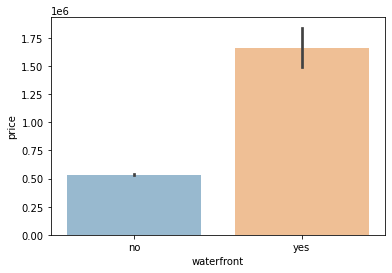

In [16]:
# media com o sem vista para o mar
mean_water_view    = data.loc[ data.waterfront == 1, 'price'].mean()
mean_no_water_view = data.loc[ data.waterfront == 0, 'price'].mean()

# renomeando os labels
data.waterfront = data.waterfront.apply( lambda x: 'yes' if x == 1 else 'no')

# diferença percentual
difference_water = (mean_water_view - mean_no_water_view) / mean_no_water_view * 100
print(f"Imóveis com vista para o mar são  {difference_water:.2f}% mais caro que a média")

# plotando
sns.barplot(data=data, x='waterfront', y='price', alpha=0.5);

### **H2: Imóveis com data de construção menor que 1955, são 50% mais baratos, na média.**
> 
>  Falso, imóveis com data de construção anterior a 1955 são em média 0.62% mais baratos.

 Imóveis construidos antes de 1955 são 0.62% mais baratos 


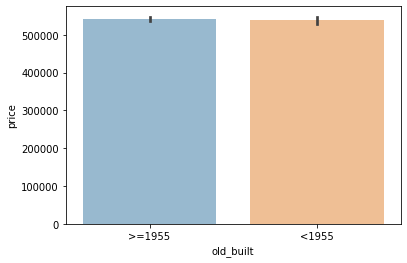

In [17]:
# media antes e depois do 1995 e diferença percentual
mean_price_before = data.loc[ (data['yr_built'] < 1955), 'price' ].mean()
mean_price_after = data.loc[ (data['yr_built'] >= 1955), 'price'].mean()
difference_price = round( (mean_price_after - mean_price_before) /  mean_price_after * 100 , 2 ) 


# criando umdataset apenas com as colunas necessárias
data_aux =  data[['id', 'price', 'yr_built']].copy()

# aplicando os labels 
data_aux['old_built'] = data.yr_built.apply( lambda x: '<1955' if (x < 1955)
                                                               else '>=1955'
                                           )
print(f" Imóveis construidos antes de 1955 são {difference_price}% mais baratos ")

# plotando
sns.barplot(data=data_aux, x=data_aux.old_built, y=data_aux.price, alpha=0.5);

### **H3: Imóveis sem porão possuem área total (srqf_lot) 40% maiores do que os imóveis com porão.****
> 
> Falso, na verdade, imóveis sem porão são **apenas 18% maiores** do que imóveis com porão.

Imóveis sem porão são certa de 18.56% maiores que imóveis com porão


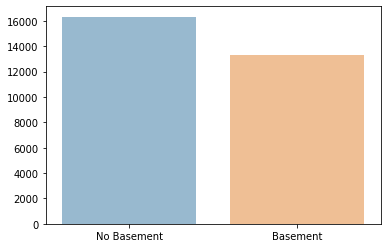

In [18]:
# média do tamanho total de imóveis com e sem porão
basement_sqft_mean = data.loc[ data.sqft_basement != 0, 'sqft_lot'].mean() 
no_basement_sqft_mean = data.loc[ data.sqft_basement == 0, 'sqft_lot'].mean() 

# diferença percentual
difference_basement = (no_basement_sqft_mean - basement_sqft_mean)/ no_basement_sqft_mean * 100
print(f"Imóveis sem porão são certa de {difference_basement:.2f}% maiores que imóveis com porão")

# plotando
sns.barplot(x=['No Basement', 'Basement'], y=[no_basement_sqft_mean, basement_sqft_mean], alpha=0.5);

### **H4: O crescimento do preço dos imóveis YoY (Year over Year- Ano a Ano) é de 10%**
>
> Falso, o crescimento do preço dos imóveis YoY é inferior a 1%


O crescimento YoY é de 0.70%.


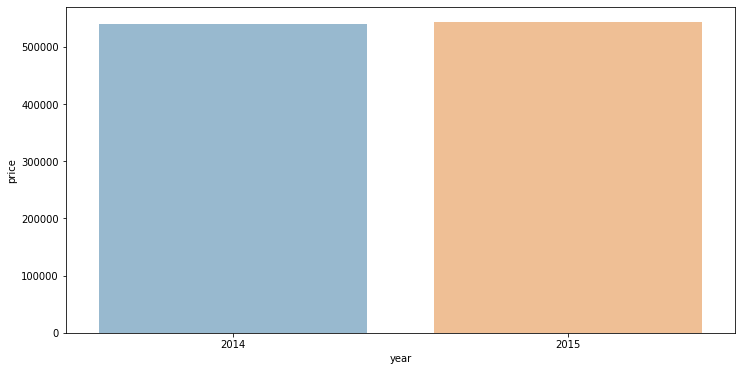

In [19]:
# Criando uma coluna por ano 
data['year'] = data.date.dt.year

# agrupando a média de preço por ano
var_YoY = data[['year', 'price']].groupby('year').mean().reset_index()

# Calculando a variação percentual 
var_YoY['var'] = var_YoY['price'].rolling(window=2).apply( lambda x: (x.iloc[1] / x.iloc[0] -1) * 100 )
print(f"O crescimento YoY é de {abs(var_YoY['var'][1]):.2f}%.")

# plotando
fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data = var_YoY, x='year', y='price', alpha=0.5);

### **H5: Imóveis com 3 banheiros tem um crescimento de MoM( Month over Month) de 15%**
>
> Falso,a variação MoM é de apenas 0.29%



Imóveis com 3 banheiros tem um crescimento MoM de 0.29% na média.


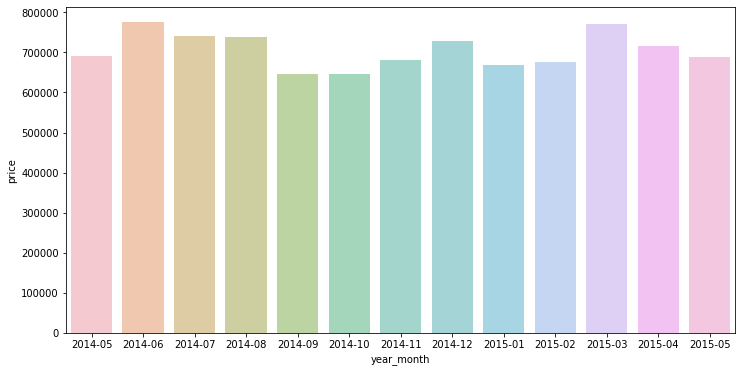

In [20]:
# criando uma coluna por ano e mês
data['year_month'] = data.date.dt.strftime("%Y-%m")

# agrupando os dados 
var_MoM = data.loc[data['bathrooms'] == 3, ['year_month', 'price']].groupby('year_month').mean().reset_index()

# criando uma nova coluna usando uma janela flutuante com dois espaços
var_MoM['var'] = var_MoM['price'].rolling(window=2).apply( lambda x: ( x.iloc[1] / x.iloc[0] -1) * 100 )
print(f"Imóveis com 3 banheiros tem um crescimento MoM de {var_MoM['var'].mean():.2f}% na média.")


# plotando
# ax1 = sns.set_style(style=None, rc=None )
fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data = var_MoM, x='year_month', y='price', alpha=0.5, ax=ax1);

# sns.lineplot(data = var_MoM['var'], marker='o',color='red', sort = False, ax=ax1)
# ax2 = ax1.twinx()


### **H6: Inverno é a estação do ano em que a média de vendas é maior**
>
> Falso, as estações do ano em que a média de vendas são maiores, são respectivcamente, Primevera e Verão.



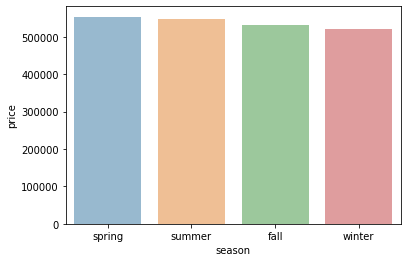

In [21]:
# agrupando os dados por preço e temporada e ordenando de maneira crescente
by_season = data[['price', 'season']].groupby('season').mean().reset_index().sort_values(by='price', ascending= False)

# plotando
sns.barplot(data=by_season, x='season', y='price', alpha=0.5);

### **H7: Imóveis não reformados são 10% mais baratos do que a média dos imóveis reformados por região.**
>
> Falso, porém, imóveis não reformados são até 17% mais baratos.

Imóveis nunca reformados são em média, 17.25% mais baratos que a média dos imóveis não reformados, por região.


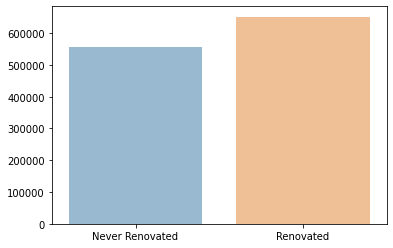

In [22]:
# Imóveis nunca reformados
no_renovated = data.loc[ data.yr_renovated == 0, ['zipcode', 'price']].groupby('zipcode').mean().reset_index()
no_renovated.columns = [ 'zipcode', 'mean_price_no_renovated']

# imóveis já reformados
renovated = data.loc[ data.yr_renovated != 0, ['zipcode', 'price']].groupby('zipcode').mean().reset_index()
renovated.columns = [ 'zipcode', 'mean_price_renovated']

# juntando os dataframes
is_renovated = pd.merge(no_renovated, renovated, how='left', on='zipcode')

dif = (is_renovated.mean_price_renovated.mean() / is_renovated.mean_price_no_renovated.mean() -1)*100

print(f"Imóveis nunca reformados são em média, {dif:.2f}% mais baratos que a média dos imóveis não reformados, por região.")

sns.barplot(x=['Never Renovated', 'Renovated'], y=[is_renovated.mean_price_no_renovated.mean(), is_renovated.mean_price_renovated.mean()], alpha=0.5);

### H8: Imóveis com 3 banheiros ou mais são 20% mais caros do que imóveis com menos que 3 banheiros
>
> Falso, são na verdade 105% mais caros.



Imóveis com 3 ou mais banheiros são 105.64% mais caros


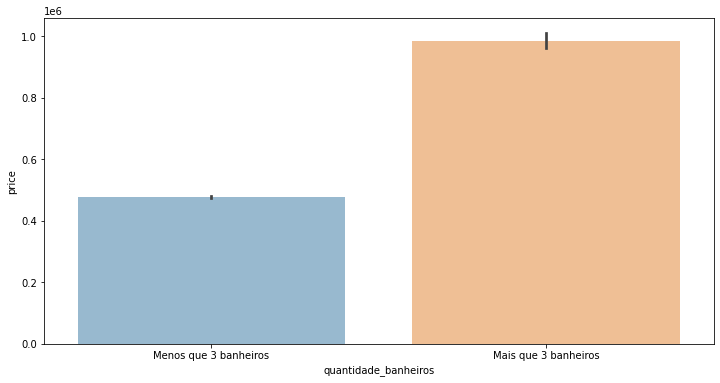

In [23]:
# agrupando os dados

bathrooms = data[['bathrooms', 'price']].copy()
bathrooms['quantidade_banheiros'] =  data.bathrooms.apply( lambda x: 'Mais que 3 banheiros' if x>=3 else 'Menos que 3 banheiros')


bathrooms_agrupados = bathrooms[['quantidade_banheiros', 'price']].groupby('quantidade_banheiros').mean().reset_index()

dif_bathrooms = ( bathrooms_agrupados.price[0] / bathrooms_agrupados.price[1] - 1 ) * 100

print(f"Imóveis com 3 ou mais banheiros são {dif_bathrooms:.2f}% mais caros")

fig, ax1 = plt.subplots(figsize=(12,6))
sns.barplot(data=bathrooms, x='quantidade_banheiros', y='price', alpha=0.5);

### H9: Imóveis com 3 quartos ou mais são 40% mais caros do que imóveis com menos que 3 quartos
>
> 



In [24]:
# bedrooms =  data[['bedrooms', 'price']].copy()
# bedrooms['quantidade_quartos'] = data.bedrooms.apply( lambda x: 'Mais que 3 quartos' if x >=3 else 'Menos que 3 quartos')

# sns.barplot(data=bedrooms, x='quantidade_quartos', y='price', alpha=0.5);

42.52%


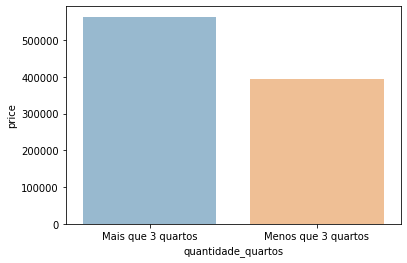

In [25]:
bedrooms =  data[['bedrooms', 'price']].copy()
bedrooms['quantidade_quartos'] = data.bedrooms.apply( lambda x: 'Mais que 3 quartos' if x >=3 else 'Menos que 3 quartos')

aux = bedrooms[['price', 'quantidade_quartos']].groupby('quantidade_quartos').mean().reset_index()
print(f"{(aux.price[0] / aux.price[1] - 1) * 100:.2f}%")

sns.barplot(data=aux, x='quantidade_quartos', y='price', alpha=0.5);